Prediction vs Actual Results:
      Date                       Match Actual Result Predicted Result
01/12/2013           Hull vs Liverpool      Home Win         Home Win
01/09/2013     Liverpool vs Man United      Home Win         Home Win
05/10/2013 Liverpool vs Crystal Palace      Home Win         Home Win
27/04/2013      Newcastle vs Liverpool      Away Win             Draw
05/05/2013        Liverpool vs Everton          Draw             Draw

Logistic Regression Accuracy: 0.80
Logistic Regression Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         3

    accuracy                           0.80         5
   macro avg       0.50      0.67      0.56         5
weighted avg       0.70      0.80      0.73         5



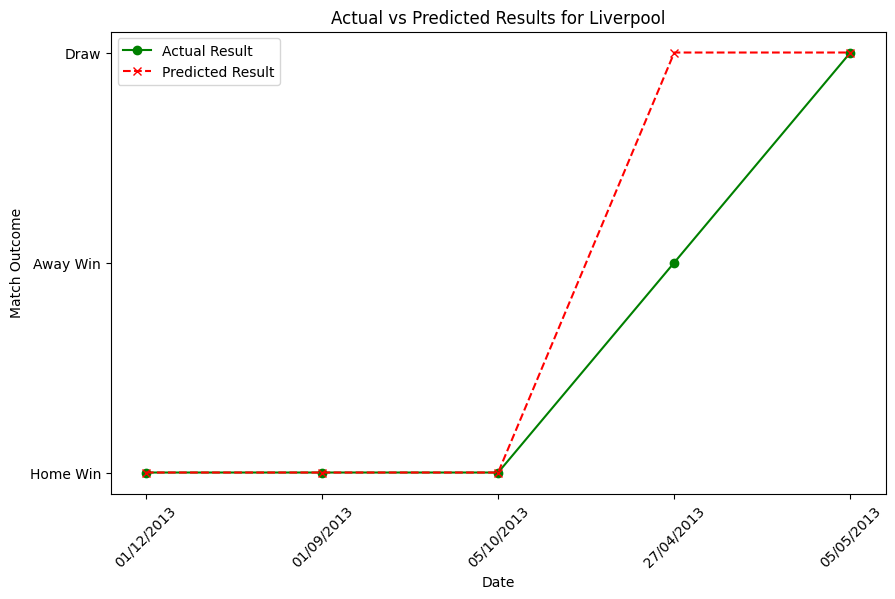

In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Parameters for customization
team_name = 'Liverpool'  # You can change this to any other team
year = 2013  # You can change this to any other year

# Load the dataset
file_path = '/content/drive/MyDrive/EPL/final_dataset (10-15).xlsx'
df = pd.read_excel(file_path)

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the specified team and year
team_matches = df[((df['HomeTeam'] == team_name) | (df['AwayTeam'] == team_name)) & (df['Date'].dt.year == year)]

# Check if there are at least 15 matches (10 for training, 5 for testing)
if len(team_matches) < 15:
    raise ValueError(f"Not enough matches found for {team_name} in {year}. At least 15 matches are required.")

# Sort by date
team_matches = team_matches.sort_values(by='Date')

# Prepare the features and target variable
team_matches['FTR'] = team_matches['FTR'].map({'H': 1, 'A': -1, 'D': 0})
team_matches['RecentForm'] = team_matches['FTHG'] - team_matches['FTAG']

# Add new features: Home Shots (HS), Away Shots (AS), Home Shots on Target (HST), Away Shots on Target (AST)
features = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'RecentForm', 'HS', 'AS', 'HST', 'AST']
for feature in features:
    if feature not in team_matches.columns:
        raise ValueError(f"Feature '{feature}' not found in the dataset.")

# Prepare the feature matrix X and target vector y
X = team_matches[features]
y = team_matches['FTR']

# Use the first 10 matches for training
X_train = X.iloc[:10]
y_train = y.iloc[:10]

# Randomly select 5 matches from the remaining matches for testing
remaining_matches = X.iloc[10:]
y_remaining = y.iloc[10:]

# Ensure that the random selection uses indices that exist in remaining_matches
random_indices = np.random.choice(remaining_matches.index, size=5, replace=False)
X_test = remaining_matches.loc[random_indices]
y_test = y_remaining.loc[random_indices]

# Initialize and train Logistic Regression model
log_reg = LogisticRegression(solver='liblinear', penalty='l2', random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

# Get match details for test data
test_matches = team_matches.loc[remaining_matches.index].loc[random_indices].reset_index(drop=True)

# Display predictions vs actual results
results = pd.DataFrame({
    'Date': test_matches['Date'].dt.strftime('%d/%m/%Y'),
    'Match': test_matches['HomeTeam'] + ' vs ' + test_matches['AwayTeam'],
    'Actual Result': y_test.map({1: 'Home Win', 0: 'Draw', -1: 'Away Win'}).values,
    'Predicted Result': pd.Series(y_pred_log_reg).map({1: 'Home Win', 0: 'Draw', -1: 'Away Win'}).values
})

print("Prediction vs Actual Results:")
print(results.to_string(index=False))

# Evaluate the Logistic Regression model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f'\nLogistic Regression Accuracy: {accuracy_log_reg:.2f}')
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg, zero_division=0))

# Plot Actual vs Predicted Results
plt.figure(figsize=(10, 6))
plt.plot(results['Date'], results['Actual Result'], marker='o', linestyle='-', color='g', label='Actual Result')
plt.plot(results['Date'], results['Predicted Result'], marker='x', linestyle='--', color='r', label='Predicted Result')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Match Outcome')
plt.title(f'Actual vs Predicted Results for {team_name}')
plt.legend()
plt.show()
